<a href="https://colab.research.google.com/github/RonnyGuevara/Computer_Graphics/blob/main/TP4/CG4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Curva de Besiel
#Código HTML

In [ ]:
<doctype html>
<html>
	<head>
		<title>FCG 2021 - TP3</title>

		<!-- estilo-->
		<link href="style.css" rel="stylesheet">

		<!--js del proyecto -->
		<script src="https://ajax.googleapis.com/ajax/libs/jquery/3.5.1/jquery.min.js"></script>
		<script type="text/javascript" id="includedscript" src="tp3.js"></script>
		<script type="text/javascript" id="includedscript" src="ejercicio.js"></script>

	</head>
	<body>
	<canvas id="canvas"></canvas>
		<svg id="overlay">
			<path id="curve" />
			<g id="lines">
				<line id="line0" />
				<line id="line1" />
				<line id="line2" />
			</g>
			<circle id="p0" />
			<circle id="p1" />
			<circle id="p2" />
			<circle id="p3" />
		</svg>
	</body>
</html>

#Código JAVA

In [ ]:
/********** CONTROLES DE LA UI Y ACTUALIZACIÓN DE LOS COMPONENTES SVG **********/

// Arreglo con los 4 puntos de control y el punto seleccionado (click del mouse)
var pt    = new Array(4);
var selPt = null;

// Cuando la página está cargada, preparo los elementos en el canvas
$(document).ready(function() 
{
	// Obtenemos el ancho y el alto del documento
	var w = document.documentElement.clientWidth;
	var h = document.documentElement.clientHeight;

	// Obtenemos los 4 círculos del canvas (circle) 
	// Estos círculos actuan como puntos de control de la curva
	pt[0] = document.getElementById("p0");
	pt[1] = document.getElementById("p1");
	pt[2] = document.getElementById("p2");
	pt[3] = document.getElementById("p3");

	// Posiciones iniciales para los 4 puntos
	// Las elegí para que abarquen el áera de la pantalla, pero se pueden cambiar a gusto
	pt[0].setAttribute("cx", 0.1*w);
	pt[0].setAttribute("cy", 0.1*h);

	pt[1].setAttribute("cx", 0.35*w);
	pt[1].setAttribute("cy", 0.6*h);
	
	pt[2].setAttribute("cx", 0.55*w);
	pt[2].setAttribute("cy", 0.3*h);
	
	pt[3].setAttribute("cx", 0.8*w);
	pt[3].setAttribute("cy", 0.9*h);
	
	// ********** Sección para linkear distintos eventos ********** //

	// MOUSE-DOWN: Al apretar el botón del mouse
	$("circle").on( "mousedown", function( event ) 
	{
		if ( ! selPt ) selPt = event.target; // selecciono el punto sobre el que sucedió el evento
	});

	// MOUSE-UP: Al soltar el botón del mouse
	$("circle").on( "mouseup", function( event ) 
	{
		selPt = null; // quito la selección cuando el usuario levanta el dedo del mouse
	});

	// MOUSE-LEAVE: Al salir del foco también libero la selección
	$(document).on( "mouseleave", function( event ) 
	{
		selPt = null; // quito la selección cuando el usuario levanta el dedo del mouse
	});

	// MOUSE-MOVE: Al mover el mouse
	$(document).on( "mousemove", function( event ) 
	{
		// Si hay un círuclo seleccionado...
		if ( selPt ) 
		{
			// ... actualizo la prosición de ese punto para que se mueva junto con el mouse
			selPt.setAttribute("cx", event.clientX);
			selPt.setAttribute("cy", event.clientY);

			// También actualizo las lineas que conectan los puntos de control y la curva objetivo
			UpdateLines();

			// y finalmente actualizo la posición de los puntos y redibujo mi escena WebGL
			UpdatePoints();			
			DrawScene();
		}
	});

	// RESIZE: Si me cambian el tamaño de la ventana del navegador...
	$(window).on( "resize", function( event ) 
	{
		// ...también tengo que actualizar el tamaño del canvas y del viewport,
		UpdateCanvasSize();

		// y redibujar mi escena WebGL en este nuevo tamaño.
		DrawScene();
	});

	// ********** Fin de linkeo de eventos ********** //

	// 1) Actualizo las lineas que conectan los puntos de control y la curva objetivo	
	UpdateLines();

	// 2) Inicializo mi ventana WebGL
	InitWebGL();

	// 3) Actualizo la posición de los puntos y redibujo mi escena WebGL
	UpdatePoints();
	DrawScene();

});

// Función par actualizar las lineas que conectan los puntos de control y la curva punteada objetivo (Bezier)
function UpdateLines()
{
	// Son tres segmentos de lineas
	var line = new Array(3);
	
	// En index.html ya definimos 3 segmentos de linea dentro del canvas
	// Vamos a obtenerlos y a actualziar sus coordeandas de inicio y fin
	line[0] = document.getElementById("line0");
	line[1] = document.getElementById("line1");
	line[2] = document.getElementById("line2");

	// Auxiliares para ir recorriendo los puntos de control
	var x1 = pt[0].getAttribute("cx");
	var y1 = pt[0].getAttribute("cy");

	// String con la información de los puntos de control para la curva Bezier
	var d = "M" + x1 + "," + y1 + " C";

	// Visitamos cada punto (empezando en 1)
	for ( var i=0; i<3; ++i ) 
	{
		// Obtenemos su x e y
		var x2 = pt[i+1].getAttribute("cx");
		var y2 = pt[i+1].getAttribute("cy");

		// Conectamos inicio y fin de la linea recta
		line[i].setAttribute("x1", x1);
		line[i].setAttribute("y1", y1);
		line[i].setAttribute("x2", x2);
		line[i].setAttribute("y2", y2);

		// Coordenadas para el path
		d += x2 + "," + y2 + " ";

		// Avanzamos al siguiente punto
		x1 = x2;
		y1 = y2;
	}
	
	// Seteamos el atributo de los puntos de control en el path
	// Más detalles en https://www.w3schools.com/graphics/svg_path.asp
	// var c = document.getElementById("curve");
	// c.setAttribute("d",d);
}

/********** INICIALIZACIÓN DEL ENTORNO WEBGL **********/

var lineDrawer;  // Objeto para condensar el comportamiento necesario para dibujar lineas (ver al final)
var curveDrawer; // Objeto para condensar el comportamiento necesario para dibujar curvas (ver ejercicio.js)

// Inicializamos del contexto WebGL
function InitWebGL()
{
	// Inicializamos el canvas
	// Es el mismo para WebGL y para los componentes SVG
	const canvas         = document.getElementById("canvas");
	canvas.oncontextmenu = function() {return false;};

	// Contexto GL
	gl = canvas.getContext("webgl", {antialias: false, depth: false});	
	if (!gl) 
	{
		alert("No se pudo inicializar WebGL. Es probable que tu navegador no lo soporte.");
		return;
	}
	
	// Color "clear" y ancho de linea (blanco)
	gl.clearColor(0.8, 0.8, 0.8, 1.0);
	gl.lineWidth(1.0);
	
	// Tenemos dos programas (dos conjuntos de shaders)
	// Para ambos, su comportamiento y buffers están contenidos en  
	// dos clases: LineDrawer y CurveDrawer
	lineDrawer  = new LineDrawer();
	curveDrawer = new CurveDrawer();
	
	// Configuramos el tamaño del canvas
	UpdateCanvasSize();
}

// Configuración del tamaño del canvas, se ejecuta al inicilizar
// y también cada vez que se cambia el tamaño de la ventana del navegador
function UpdateCanvasSize()
{
	// Obtenemos el canvas
	const canvas        = document.getElementById("canvas");

	// Calculamos la resolución en base al pixelRatio
	canvas.style.width  = '100%';
	canvas.style.height = '100%';
	const pixelRatio    = window.devicePixelRatio || 1;
	canvas.width        = pixelRatio * canvas.clientWidth;
	canvas.height       = pixelRatio * canvas.clientHeight;
	const width         = (canvas.width  / pixelRatio);
	const height        = (canvas.height / pixelRatio);

	// Actualizamos el tamaño del canvas
	canvas.style.width  = width  + 'px';
	canvas.style.height = height + 'px';

	// Actualizamos el tamaño del viewport (= al canvas)
	gl.viewport( 0, 0, canvas.width, canvas.height );
	
	// Finalmente actualizamos las matrices de proyección (para los segmentos
	// y para las curvas) utilizando el nuevo tamaño del viewport
	lineDrawer.setViewport( width, height );
	curveDrawer.setViewport( width, height );
}

// Actualizamos la posición de los puntos de control
// Se llama cada vez que el usuario los mueve con el mouse (ver mousemove)
function UpdatePoints()
{
	// Actualizamos los puntos de control de las lineas rectas
	lineDrawer.updatePoints(pt);

	// Actualizamos los puntos de control de la curva de bezier
	curveDrawer.updatePoints(pt);
}

// Función para dibujar la escena WebGL completa. Limpia el viewport
// y le pide a cada programa que se dibuje
function DrawScene()
{
	// Limpiamos la pantalla (y el bufer de profundidad, algo que no estamos usando
	// y podríamos borrarlo de esta linea sin ningún efecto) 
	gl.clear(gl.COLOR_BUFFER_BIT | gl.DEPTH_BUFFER_BIT);
	
	// Le pedimos a las lineas y a la curva bezier que se dibujen 
	// (ver las definiciónes en las clases LineDrawer y CurveDrawer)
	curveDrawer.draw();
	lineDrawer.draw();
}

// Función que compila los shaders que se le pasan por parámetro (vertex & fragment shaders)
// Recibe lso strings de cada shader y retorna un programa
function InitShaderProgram( vsSource, fsSource )
{
	// Función que compila cada shader individualmente
	const vs = CompileShader( gl.VERTEX_SHADER,   vsSource );
	const fs = CompileShader( gl.FRAGMENT_SHADER, fsSource );

	// Crea y linkea el programa 
	const prog = gl.createProgram();
	gl.attachShader(prog, vs);
	gl.attachShader(prog, fs);
	gl.linkProgram(prog);

	if (!gl.getProgramParameter(prog, gl.LINK_STATUS)) 
	{
		alert('No se pudo inicializar el programa: ' + gl.getProgramInfoLog(prog));
		return null;
	}
	return prog;
}

// Función para compilar shaders, recibe el tipo (gl.VERTEX_SHADER o gl.FRAGMENT_SHADER)
// y el código en forma de string. Es llamada por InitShaderProgram()
function CompileShader( type, source )
{
	// Creamos el shader
	const shader = gl.createShader(type);

	// Lo compilamos
	gl.shaderSource(shader, source);
	gl.compileShader(shader);

	// 	Verificamos si la compilación fue exitosa
	if (!gl.getShaderParameter( shader, gl.COMPILE_STATUS) ) 
	{
		alert('Ocurrió un error durante la compilación del shader:\n' + gl.getShaderInfoLog(shader));
		gl.deleteShader(shader);
		return null;
	}
	return shader;
}

/********** CLASE PARA DIBUJAR LOS SEGMENTOS ENTRE LOS PUNTOS DE CONTROL USANDO WEBGL **********/

// Clase muy similar a CurveDrawer. Pueden utilizarla como modelo para resolver el TP. 
class LineDrawer 
{
	// Inicialización de los shaders y buffers
	constructor()
	{
		// Creamos el programa webgl con los shaders para los segmentos de recta
		this.prog = InitShaderProgram( linesVS, linesFS );

		// Obtenemos la ubicación de las varibles uniformes en los shaders,
		// en este caso, la matriz de transformación 'mvp'
		this.mvp = gl.getUniformLocation( this.prog, 'mvp' );
		
		// Obtenemos la ubicación de los atributos de los vértices
		// en este caso, la posición 'pos'
		this.vertPos = gl.getAttribLocation( this.prog, 'pos' );
				
		// Creamos el buffer para los vértices.
		// En este caso no tenemos triángulos, pero si segmentos 
		// definidos entre dos puntos. 
		this.buffer = gl.createBuffer();

		// Si bien creamos el buffer, no vamos a ponerle contenido en este
		// constructor. La actualziación de la información de los vértices
		// la haremos dentro de updatePoints().
		
	}

	// Actualización del viewport (se llama al inicializar la web o al cambiar el tamaño de la pantalla)
	setViewport( width, height )
	{		
		// Calculamos la matriz de proyección.
		// Como nos vamos a manejar únicamente en 2D, no tiene sentido utilizar perspectiva. 
		// Simplemente inicializamos la matriz para que escale los elementos de la escena
		// al ancho y alto del canvas, invirtiendo la coordeanda y. La matriz está en formato 
		// column-major.
		var trans = [ 2/width,0,0,0,  0,-2/height,0,0, 0,0,1,0, -1,1,0,1 ];

		// Seteamos la matriz en la variable unforme del shader
		gl.useProgram( this.prog );
		gl.uniformMatrix4fv( this.mvp, false, trans );
	}

	// Cambiaron los puntos de control, asi que tenemos que actualziar los datos en el buffer
	updatePoints( pt )
	{
		// Armamos el arreglo
		var p = [];
		for ( var i=0; i<4; ++i ) 
		{
			var x = pt[i].getAttribute("cx");
			var y = pt[i].getAttribute("cy");
			
			p.push(x);
			p.push(y);
		}

		// Enviamos al buffer
		gl.bindBuffer(gl.ARRAY_BUFFER, this.buffer);
		gl.bufferData(gl.ARRAY_BUFFER, new Float32Array(p), gl.STATIC_DRAW);
	}

	// Dibujamos los segmentos de linea
	draw()
	{
		// Seleccionamos el shader
		gl.useProgram( this.prog );

		// Binding del buffer de posiciones
		gl.bindBuffer( gl.ARRAY_BUFFER, this.buffer );

		// Habilitamos el atributo 
		gl.vertexAttribPointer( this.vertPos, 2, gl.FLOAT, false, 0, 0 );
		gl.enableVertexAttribArray( this.vertPos );

		// Dibujamos lineas utilizando primitivas gl.LINE_STRIP 
		// https://developer.mozilla.org/en-US/docs/Web/API/WebGLRenderingContext/drawArrays
		gl.drawArrays( gl.LINE_STRIP, 0, 4 );
	}
}

// Vertex shader de las rectas que unen los puntos de control
// Simplemente transforma el vector a coordenadas homogéneas y aplica la matriz de transformación
var linesVS = `
	attribute vec2 pos;
	uniform mat4 mvp;
	void main()
	{
		gl_Position = mvp * vec4(pos,0,1);
	}
`;

// Fragment shader de las rectas que unen los puntos de control
// Simplemente devuelve un color para cada fragmento, en este caso, rojo
var linesFS = `
	precision mediump float;
	void main()
	{
		gl_FragColor = vec4(1,0,0,1);
	}
`;


In [ ]:
// Completar la implementación de esta clase y el correspondiente vertex shader. 
// En principio no es necesario modificar el fragment shader, salvo que quieren modificar el color de la curva
class CurveDrawer 
{
	// Inicialización de los shaders y buffers
	constructor()
	{
		// Creamos el programa webgl con los shaders para los segmentos de recta
		this.prog   = InitShaderProgram( curvesVS, curvesFS);

		// Muestreo del parámetro t: Genero una secuencia de 100 valores reales entre 0 y 1
		this.steps = 100;
		var tv = [];
		for ( var i=0; i<this.steps; ++i ) {
			tv.push( i / (this.steps-1) );
		}
		
		// [Completar] Creacion del vertex buffer y seteo de contenido
		// createbuffer, bindbuffer, bufferdata
		this.buffer = gl.createBuffer();
		gl.bindBuffer(gl.ARRAY_BUFFER, this.buffer );
		gl.bufferData(gl.ARRAY_BUFFER, new Float32Array(tv), gl.STATIC_DRAW);

		// [Completar] Incialización y obtención de las ubicaciones de los atributos y variables uniformes de los shaders	
		this.mvp = gl.getUniformLocation (this.prog, 'mvp');
		this.p0 = gl.getUniformLocation (this.prog, 'p0');
		this.p1 = gl.getUniformLocation (this.prog, 'p1');
		this.p2 = gl.getUniformLocation (this.prog, 'p2');
		this.p3 = gl.getUniformLocation (this.prog, 'p3');
		this.t = gl.getAttribLocation (this.prog, 'tv');
		
	
	}

	// Actualización del viewport (se llama al inicializar la web o al cambiar el tamaño de la pantalla)
	setViewport( width, height )
	{
		const pixelRatio = window.devicePixelRatio || 1;
		canvas.width     = pixelRatio * canvas.clientWidth;
		canvas.height    = pixelRatio * canvas.clientHeight;
		gl.viewport(0, 0, canvas.width, canvas.height);

		// [Completar] Matriz de transformación los puntos están en coordenadas de pantalla. .
		var trans = [ 2/width,            0,		0,		0,
					  		0,	  -2/height,		0,		0,
					  		0,	          0,		1,		0,
					 	   -1,	          1,		0,		1];

		// [Completar] Binding del programa y seteo de la variable uniforme para la matriz. 
		gl.useProgram( this.prog);
		gl.uniformMatrix4fv( this.mvp, false, trans);

	}

	updatePoints( pt )
	{
	
		/*var p = [];
		for ( var i=0; i<4; ++i ) 
		{
			var x = pt[i].getAttribute("cx");
			var y = pt[i].getAttribute("cy");
		
			p.push(x);
			p.push(y);
		}*/
		// [Completar] Pueden acceder a las coordenadas de los puntos de control consultando el arreglo pt[]:
		// [Completar] No se olviden de hacer el binding del programa antes de setear las variables 
		// [Completar] Actualización de las variables uniformes para los puntos de control

		// var x = pt[i].getAttribute("cx");
		// var y = pt[i].getAttribute("cy");


		var p0 = [pt[0].getAttribute("cx"), pt[0].getAttribute("cy")];
		var p1 = [pt[1].getAttribute("cx"), pt[1].getAttribute("cy")];
		var p2 = [pt[2].getAttribute("cx"), pt[2].getAttribute("cy")];
		var p3 = [pt[3].getAttribute("cx"), pt[3].getAttribute("cy")];

		gl.useProgram(this.prog);
		gl.uniform2fv(this.p0, p0);
		gl.uniform2fv(this.p1, p1);
		gl.uniform2fv(this.p2, p2);
		gl.uniform2fv(this.p3, p3);

	}

	draw()
	{

		gl.useProgram( this.prog );
		gl.bindBuffer( gl.ARRAY_BUFFER, this.buffer);
		gl.vertexAttribPointer( this.t, 1, gl.FLOAT, false, 0, 0 ); //gl.vertexAttribPointer(attributeLocations.curveness, numComponents, type, normalize, stride, offset);
		gl.enableVertexAttribArray( this.t);
		gl.drawArrays( gl.LINE_STRIP, 0, 100);
		
		
		// [Completar] No se olviden de hacer el binding del programa y de habilitar los atributos de los vértices
		// [Completar] Setear los valores uniformes del Vertex shader.
	}
}

// Vertex Shader
//[Completar] El vertex shader se ejecuta una vez por cada punto en mi curva (parámetro step). No confundir punto con punto de control.
// Deberán completar con la definición de una Bezier Cúbica para un punto t. Algunas consideraciones generales respecto a GLSL: si
// declarás las variables pero no las usás, no se les asigna espacio. Siempre poner ; al finalizar las sentencias. Las constantes
// en punto flotante necesitan ser expresadas como X.Y, incluso si son enteros: ejemplo, para 4 escribimos 4.0
var curvesVS = `

	attribute float tv;
	uniform mat4 mvp;
	
	uniform vec2 p0;
	uniform vec2 p1;
	uniform vec2 p2;
	uniform vec2 p3;

	void main()
	{ 
		//[completar]
		gl_Position = mvp * vec4(p0 * pow(1.0-tv,3.0) + p1 * (3.0*tv) * pow(1.0-tv,2.0) + p2 * 3.0 * pow(tv,2.0) * (1.0-tv) + p3 * pow(tv,3.0), 0, 1);		
	}
`;

// Fragment Shader
var curvesFS = `

	precision mediump float;

	void main()
	{
		//[ Salvo que te moleste que se vea azul, no deberías tocarlo :P ]
		gl_FragColor = vec4(0,0,1,1);
	}
`;

#Resultado

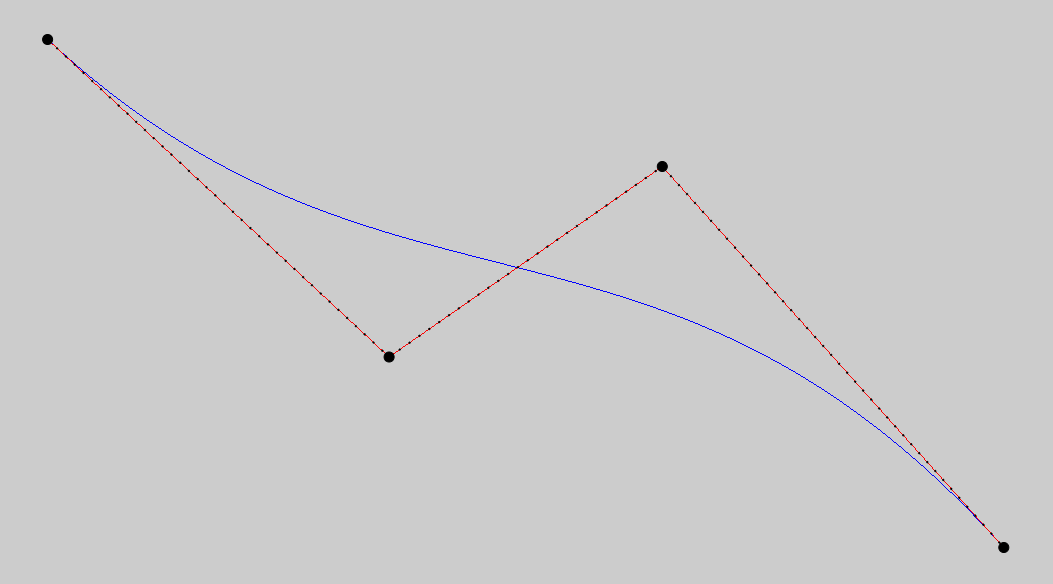

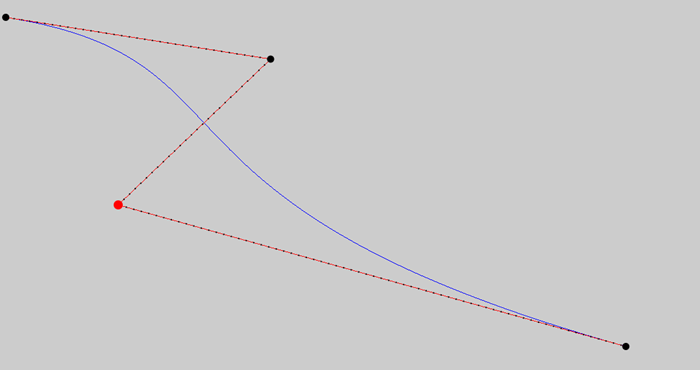